# Home Credit Default Risk Competition

### https://www.kaggle.com/c/home-credit-default-risk

### Major references:
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
* https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
* https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search

## Pre-processing and Feature Engineering

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
app_train = pd.read_csv('input/application_train.csv')
app_test = pd.read_csv('input/application_test.csv')
bureau = pd.read_csv('input/bureau.csv')
bureau_balance = pd.read_csv('input/bureau_balance.csv')

## Manual Feature Engieering

### Summarize information from all other tables
Extract useful information from other tables
* Using Groupby is quick and dirty, but help me to build up a baseline model to play around.
* Consider using other method to extract information could be helpful in later stage.

### 1. Previous_loan_counts

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()\
                             .rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
# Meger data
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_test['previous_loan_counts'] = app_test['previous_loan_counts'].fillna(0)

# delete tmp variable
del previous_loan_counts

### 2. Aggregating Numeric Columns

In [ ]:
"""
Function for Numeric Aggregations:
This will allow us to compute aggregate stats for numeric columns across any dataframe. 
We will re-use this function when we want to apply the same operations for other dataframes.
"""

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(col, axis =1)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes(include=['number'])
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [ ]:
# Group by the client id, calculate aggregation statistics
bureau_agg = agg_numeric(bureau.drop(['SK_ID_BUREAU'],axis=1), group_var = 'SK_ID_CURR', df_name = 'bureau')

# Merge data
app_train = pd.merge(app_train, bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, bureau_agg, on = 'SK_ID_CURR', how = 'left')

del bureau_agg

### 3. Categorical Variables

In [ ]:
"""
Function to Handle Categorical Variables:
This will take the same form as the "agg_numeric()" function in that 
it accepts a dataframe and a grouping variable. Then it will calculate 
the counts and normalized counts of each category for all categorical 
variables in the dataframe.
"""

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes(include=['object']))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    categorical.reset_index(level=0, inplace=True)

    return categorical

In [ ]:
bureau_categorical_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

# Merge data
app_train = pd.merge(app_train, bureau_categorical_counts, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, bureau_categorical_counts, on = 'SK_ID_CURR', how = 'left')

del bureau_categorical_counts

### Applying the Same Operation to Bureau Balance table

In [ ]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [ ]:
bureau_by_loan = pd.merge(bureau_balance_agg, bureau_balance_counts, on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = pd.merge(bureau_by_loan, bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
del bureau_balance_counts, bureau_balance_agg

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(['SK_ID_BUREAU'],axis=1), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client['SK_ID_CURR'] = bureau_balance_by_client['SK_ID_CURR'].astype(int)

app_train = pd.merge(app_train, bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

del bureau_balance_by_client, bureau, bureau_balance

In [ ]:
gc.enable()
gc.collect()

### Adding other tables as well

The definitions of the four additional data files are:

* previous_application (called previous): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE (called cash): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance (called credit): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment (called installments): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

### previous_application.csv

In [ ]:
previous = pd.read_csv('input/previous_application.csv')
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous.drop(['SK_ID_PREV'],axis=1),\
                           group_var = 'SK_ID_CURR', df_name = 'previous_loans')
previous_counts = count_categorical(previous, group_var = 'SK_ID_CURR', df_name = 'previous_loans')

In [ ]:
# Merge in the previous information
app_train = pd.merge(app_train, previous_counts, on ='SK_ID_CURR', how = 'left')
app_train = pd.merge(app_train, previous_agg, on ='SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, previous_counts, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

### Other 3 loan based tables 

In [ ]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'object'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop([group_vars[0]], axis=1)

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop([group_vars[0]],axis=1)
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### Monthly Credit Data

In [ ]:
credit = pd.read_csv('input/credit_card_balance.csv')

credit_by_client = aggregate_client(credit, 
                                    group_vars = ['SK_ID_PREV', 'SK_ID_CURR'],
                                    df_names = ['credit', 'client'])

app_train = pd.merge(app_train, credit_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

### Monthly Cash Data

In [ ]:
cash = pd.read_csv('input/POS_CASH_balance.csv')

cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])

app_train = pd.merge(app_train, cash_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

### Installment Payments

In [ ]:
installments = pd.read_csv('input/installments_payments.csv')

installments_by_client = aggregate_client(installments, 
                                          group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])

app_train = pd.merge(app_train, installments_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = pd.merge(app_test, installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
app_train.shape

In [ ]:
app_train.to_csv('train_all_raw.csv', index = False)
app_test.to_csv('test_all_raw.csv', index = False)

In [ ]:
app_train = pd.read_csv('train_all_raw.csv')
app_test = pd.read_csv('test_all_raw.csv')

## Features Proccessing

### Tagging NaNs and fill them with median

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(missing_columns, axis=1)
    test = test.drop(missing_columns, axis=1)
    
    return train, test

In [ ]:
app_train, app_test = remove_missing_columns(app_train, app_test, threshold = 80)

In [ ]:
missing_values_table(app_train).head()

In [ ]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

In [ ]:
def tagging_fill_nans(train, test):
    fill_vals = train.median(axis=0)
    for col in train:
        if col != 'TARGET' and train[col].isnull().sum() !=0:
            train[col+'nan_tag'] = train[col].isnull()
            test[col+'nan_tag'] = test[col].isnull()    

    train = train.fillna(fill_vals)
    test = test.fillna(fill_vals)
    
    return train, test

In [ ]:
app_train, app_test = tagging_fill_nans(app_train, app_test)

In [ ]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

In [ ]:
app_train = app_train.fillna(0)
app_test = app_test.fillna(0)

In [ ]:
gc.enable()
gc.collect()

In [ ]:
app_train.to_csv('train_all_fillnan.csv', index = False)
app_test.to_csv('test_all_fillnan.csv', index = False)

In [ ]:
app_train = pd.read_csv('train_all_fillnan.csv')
app_test = pd.read_csv('test_all_fillnan.csv')

### Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col]) 
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

### Polynomial features

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(['TARGET'],axis=1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train, app_test = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

app_train['TARGET'] = poly_target
# Print out the new shapes
print('Training data with polynomial features shape: ', app_train.shape)
print('Testing data with polynomial features shape:  ', app_test.shape)

In [ ]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']

print('Training data with polynomial features shape: ', app_train.shape)
print('Testing data with polynomial features shape:  ', app_test.shape)

In [ ]:
del poly_features, poly_features_test, app_train_poly, app_test_poly, poly_target

In [ ]:
app_train.to_csv('train_all_ext.csv', index = False)
app_test.to_csv('test_all_ext.csv', index = False)

In [2]:
app_train = pd.read_csv('train_all_ext.csv')
app_test = pd.read_csv('test_all_ext.csv')

## Dimension reduction

### 1. Running PCA to reduce dimension

In [3]:
from sklearn.decomposition import PCA

train_ID = app_train['SK_ID_CURR']
test_ID = app_test['SK_ID_CURR']
label = app_train['TARGET']
app_train = app_train.drop(['TARGET','SK_ID_CURR'], axis=1)
app_test = app_test.drop(['SK_ID_CURR'], axis=1)

n_PCA_features = 900   ## selecting 900 features
train_cols = ['feature_'+str(i) for i in np.arange(n_PCA_features)]
pca = PCA(n_components=n_PCA_features)

In [4]:
app_train_ar = pca.fit_transform(app_train) # This is the result 
app_train = pd.DataFrame(app_train_ar, columns=train_cols)
app_train['TARGET'] = label

In [5]:
app_test_ar = pca.transform(app_test)
app_test = pd.DataFrame(app_test_ar, columns=train_cols)

In [6]:
app_train['SK_ID_CURR'] = train_ID
app_test['SK_ID_CURR'] = test_ID

In [7]:
gc.enable()
del app_test_ar, app_train_ar
gc.collect()

35

In [8]:
print('Training data with polynomial features shape: ', app_train.shape)
print('Testing data with polynomial features shape:  ', app_test.shape)

Training data with polynomial features shape:  (307511, 902)
Testing data with polynomial features shape:   (48744, 901)


In [9]:
app_train.to_csv('train_all_pca.csv', index = False)
app_test.to_csv('test_all_pca.csv', index = False)

In [2]:
app_train = pd.read_csv('train_all_pca.csv')
app_test = pd.read_csv('test_all_pca.csv')

### 3. Just delete collinear variables

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold

In [ ]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape

### Light Gradient Boosting Machine

In [3]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'],axis=1)
    test_features = test_features.drop(['SK_ID_CURR'],axis=1)
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [5]:
# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train, app_test)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 900)
Testing Data Shape:  (48744, 900)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.772013	train's auc: 0.838548
[400]	valid's auc: 0.774071	train's auc: 0.888415
Early stopping, best iteration is:
[409]	valid's auc: 0.774335	train's auc: 0.89023
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767416	train's auc: 0.83964
[400]	valid's auc: 0.769959	train's auc: 0.889619
Early stopping, best iteration is:
[342]	valid's auc: 0.770281	train's auc: 0.877481
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.774655	train's auc: 0.838563
[400]	valid's auc: 0.776287	train's auc: 0.888503
Early stopping, best iteration is:
[326]	valid's auc: 0.776702	train's auc: 0.872641
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.770972	train's auc: 0.83856
[400]	valid's auc: 0.772774	train's auc: 0.888516
Early stopping, best itera

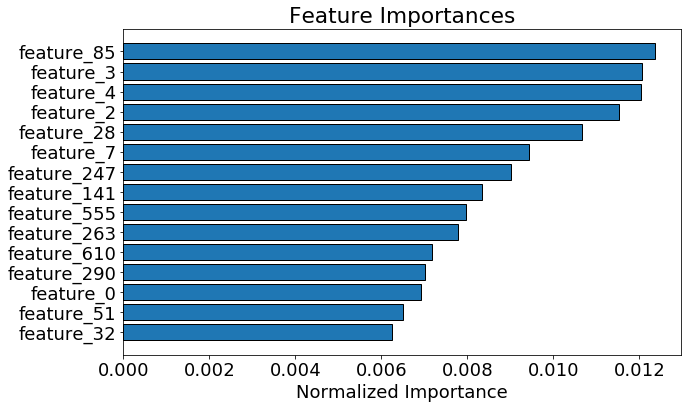

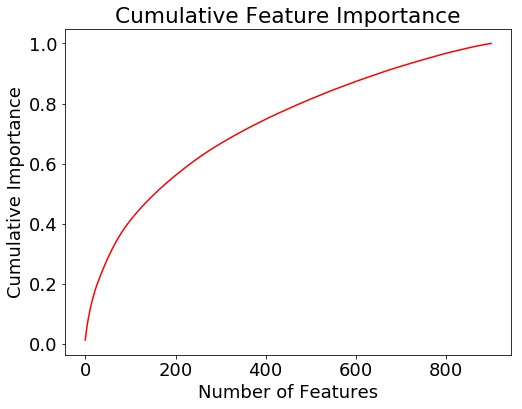

In [6]:
fi_sorted = plot_feature_importances(fi_domain)

In [15]:
submission_domain.to_csv('baseline_lgb_pca.csv', index = False)

### Drop variables with 0 importance

In [7]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
app_train = train.drop(zero_features, axis=1)
app_test = test.drop(zero_features, axis=1)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

NameError: name 'feature_importances' is not defined

## Model Tuning and Hyperparameter search

In [ ]:
# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

In [ ]:
# Extract the test ids and train labels
test_ids = app_test['SK_ID_CURR']
train_ids = app_train['SK_ID_CURR']
train_labels = np.array(app_train['TARGET'].astype(np.int32)).reshape((-1, ))

app_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
app_test = test.drop(['SK_ID_CURR'], axis=1)


# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [ ]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

In [ ]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [ ]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

In [ ]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [ ]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [ ]:
import csv

MAX_EVALS = 1000

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}


random_results = random_search(param_grid, out_file)

### Evaluate Parameter Searching result

In [ ]:
import ast

random_results = pd.read_csv('input/random_search_trials.csv')
# Convert strings to dictionaries
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

In [ ]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [ ]:
random_hyp = evaluate(random_results, name = 'random search')

In [ ]:
import altair as alt

alt.renderers.enable('notebook')

In [ ]:
# Combine results into one dataframe
random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'

hyp = random_hyp.append(grid_hyp)
hyp.head()

In [ ]:
max_random = random_hyp['score'].max()
max_grid = grid_hyp['score'].max()

c = alt.Chart(hyp, width = 400, height = 400).mark_circle(size = 150).encode(alt.Y('score', scale = alt.Scale(domain = [0.65, 0.76])),
x = 'iteration', color = 'search')

c.title = 'Score vs Iteration'
c

In [ ]:
best_grid_hyp = grid_hyp.iloc[grid_hyp['score'].idxmax()].copy()
best_random_hyp = random_hyp.iloc[random_hyp['score'].idxmax()].copy()

In [ ]:
hyp.sort_values('search', inplace = True)

# Plot of scores over the course of searching
sns.lmplot('iteration', 'score', hue = 'search', data = hyp, size = 8);
plt.scatter(best_grid_hyp['iteration'], best_grid_hyp['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.scatter(best_random_hyp['iteration'], best_random_hyp['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

### Run finer grid search and evalutae

In [ ]:
# Create file and open connection
out_file = 'grid_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

grid_results = grid_search(param_grid, out_file)


In [ ]:
grid_results = pd.read_csv('input/grid_search_trials.csv')
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)

## Train model using optimal hyperparameters

In [ ]:
# Train the model with the optimal number of estimators from early stopping
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)
                        
# Predictions on the test data
preds = model.predict_proba(test)[:, 1]

In [ ]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_simple_features_random.csv', index = False)